# Data Analysis over the Clusters
## Loading libraries

In [1]:
import numpy as np
import cygnus_lib as cy
import toolslib as tl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from iDBSCAN import iDBSCAN
from sklearn.cluster import DBSCAN


from time import time
from ast import literal_eval
from math import degrees
from math import radians
from toolslib import colorbar


## font definition
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.rcParams['font.serif'] = ['Bitstream Vera Sans']
cy.set_atlas_style('large')

sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 30, 'linewidths':0}

## Variables definition

In [2]:
x_resolution = y_resolution = 2048
rescale      = 512
scale        = int(x_resolution/rescale)
pixelscale   = 55e-3             #55e-3 for Orange ------ 0.125 for lemonn mm/pixel

cimax        = 200       # valori del cut sull'imagine
cimin        = 103       # valori del cut sull'imagine

## Loading data

List contain:

[0 - Run number, 1 - Image Number, 2 - Tag of the cluster, 3 - Pixel X position, 4 - Pixel Y position, 5 - Light in the pixel, 6 - Pedestal in the pixel]

In [3]:
tic=time()
#------------------- Loading File ------------------------------#
directory = ("./data/")          # Directory of the output file
filename  = ("toEff_L")            # Name of the output file
extension = (".csv")             # Extension of the output file
dataout   = directory + filename + extension # Full path of the output file

dt        = {'Run': np.int64, 'Image': np.int64, 'Tag': np.object, 'X': np.object, 
             'Y': np.object, 'Light': np.object, 'Pedestal': np.object}
colhead   = ["Run","Image","Tag","X","Y","Light","Pedestal"]
dfl       = pd.read_csv(dataout,dtype=dt)

dfl.loc[:,'X']        = dfl.loc[:,'X'].apply(literal_eval)
dfl.loc[:,'Y']        = dfl.loc[:,'Y'].apply(literal_eval)
dfl.loc[:,'Light']    = dfl.loc[:,'Light'].apply(literal_eval)
dfl.loc[:,'Pedestal'] = dfl.loc[:,'Pedestal'].apply(literal_eval)

In [4]:
#------------------- Loading File ------------------------------#
directory = ("./data/")          # Directory of the output file
filename  = ("toEff_M")            # Name of the output file
extension = (".csv")             # Extension of the output file
dataout   = directory + filename + extension # Full path of the output file

dt        = {'Run': np.int64, 'Image': np.int64, 'Tag': np.object, 'X': np.object, 
             'Y': np.object, 'Light': np.object, 'Pedestal': np.object}
colhead   = ["Run","Image","Tag","X","Y","Light","Pedestal"]
dfm       = pd.read_csv(dataout,dtype=dt)

dfm.loc[:,'X']        = dfm.loc[:,'X'].apply(literal_eval)
dfm.loc[:,'Y']        = dfm.loc[:,'Y'].apply(literal_eval)
dfm.loc[:,'Light']    = dfm.loc[:,'Light'].apply(literal_eval)
dfm.loc[:,'Pedestal'] = dfm.loc[:,'Pedestal'].apply(literal_eval)

In [5]:
#------------------- Loading File ------------------------------#
directory = ("./data/")          # Directory of the output file
filename  = ("toEff_S")            # Name of the output file
extension = (".csv")             # Extension of the output file
dataout   = directory + filename + extension # Full path of the output file

dt        = {'Run': np.int64, 'Image': np.int64, 'Tag': np.object, 'X': np.object, 
             'Y': np.object, 'Light': np.object, 'Pedestal': np.object}
colhead   = ["Run","Image","Tag","X","Y","Light","Pedestal"]
dfs       = pd.read_csv(dataout,dtype=dt)

dfs.loc[:,'X']        = dfs.loc[:,'X'].apply(literal_eval)
dfs.loc[:,'Y']        = dfs.loc[:,'Y'].apply(literal_eval)
dfs.loc[:,'Light']    = dfs.loc[:,'Light'].apply(literal_eval)
dfs.loc[:,'Pedestal'] = dfs.loc[:,'Pedestal'].apply(literal_eval)

toc = time()
print("Loading time: %.2f" % ((toc-tic)/60))

Loading time: 0.17


In [6]:
frames = [dfl, dfm, dfs]
df = pd.concat(frames, ignore_index = True)

del frames

In [7]:
# Showing the table
#df

In [8]:
def pointInsideCircle(Px, Py, Cx = 1024, Cy = 1024, R = 900):
    Hx = np.zeros(4,dtype=float)
    Hy = np.zeros(4,dtype=float)
    
    Hx[0] = np.min(Px)
    Hy[0] = Py[np.argmin(Px)]
    
    Hx[1] = np.max(Px)
    Hy[1] = Py[np.argmax(Px)]
      
    Hx[2] = np.min(Py)
    Hy[2] = Px[np.argmin(Py)]
    
    Hx[3] = np.max(Py)
    Hy[3] = Px[np.argmax(Py)]
    
    out = np.ones(4, dtype=bool)
    for i in range(0,len(Hx)):
        
        teste = np.sqrt((Hx[i]-Cx)**2 + (Hy[i]-Cy)**2)
        if teste < R:
            out[i] = True
        else:
            out[i] = False

    result = np.all(out)
    
    return result

In [9]:
tn = 2544549 #2544690 #2544549


# List to salve all simulated images and informations
clutruth   = []
truth      = []

pedestal   = 99

flag_angle = False
flag_bkg   = False
flag_plt   = False

runI  = [494]
nRi   = 0

ss    = [0,10,15,20,25,30,35,40,45,50]
nm    = [1,2,3,4,5,6,7,8,9,10]

nset       = 10
nfig       = 100 
nfigures   = nset*nfig

if flag_bkg == False:
    fileoutm = ("./data/run%d_mean.h5" % (runI[nRi]))
    m_image = cy.read_image_h5(fileoutm)
    fileouts = ("./data/run%d_sigma.h5" % (runI[nRi]))
    s_image = cy.read_image_h5(fileouts)

for jj in range(0,nfigures):
    print('Creating simulated images .... %.2f%%' % ((100*jj)/nfigures))
    #Background
    tag        = []
    
    if flag_bkg == True:
        dataSelection = 'LAB'
        cleImg = [4,5,7,9,15]
        iTr   = cleImg[np.random.randint(0, len(cleImg))]
        imageOri = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, runI[0], iTr)) 
        titletext = "I%d Run%d + one random long track" % (iTr, runI[0])
        #print("Using I%d Run%d as background noise" % (iTr, runI[0]))
        
    else:
        # To remove any NaN
        s_image[np.isnan(s_image)] = np.mean(s_image[~np.isnan(s_image)])
        m_image[np.isnan(m_image)] = np.mean(m_image[~np.isnan(m_image)])

        m_image[m_image > 101] = np.mean(m_image[m_image < 101])
        s_image[s_image > 4]   = np.mean(s_image[s_image < 4])

        imageOri = np.random.normal(m_image,s_image,[2048,2048])
        titletext = "Inserting background noise"
        #print("Create background noise from mean + sigma of the run")
            

    #matrix = np.zeros([y_resolution,x_resolution],dtype=int) # Background
    image    = np.copy(imageOri)

    it       = -1 
    
    nSmall   = ss[int(np.floor(jj/nfig))]
    nMedium  = nm[int(np.floor(jj/nfig))]
    nLong    = np.random.randint(0, 2)
    
    fname  = np.str(nLong) + "L" + np.str(nMedium) + "M" + np.str(nSmall) + "S"

    #rd       = np.concatenate([np.random.randint(0, dfl.shape[0],nLong),np.random.randint(11, 15 + 1,nMedium),
    #                           np.random.randint(16, 20 + 1,nSmall)])
    
    rd       = np.concatenate([np.random.randint(0, dfl.shape[0],nLong),
                               np.random.randint(dfl.shape[0], dfl.shape[0] + dfm.shape[0],nMedium),
                               np.random.randint(dfl.shape[0] + dfm.shape[0],
                                                 dfl.shape[0] + dfm.shape[0] + dfs.shape[0],nSmall)])
    
    for kk in range(0,nLong):
        tag.append('l')
    for kk in range(0,nMedium):
        tag.append('m')
    for kk in range(0,nSmall):
        tag.append('s')
        
    for ind in rd:
        it += 1
        
        if flag_angle == True:
            angle             = radians(np.random.randint(0, 360 + 1))
            #newX,newY         = tl.rotate(df.X[ind][0],df.Y[ind][0],df.X[ind],df.Y[ind],angle)
            newX,newY         = tl.rotate(df.X[ind][0],df.Y[ind][0],df.X[ind],df.Y[ind],angle)
            #newX,newY         = tl.rotate(0,0,df.X[ind],df.Y[ind],angle)
            newX              = np.round(newX).astype(int)
            newY              = np.round(newY).astype(int)

            if np.min(newX) <= 0:
                newX = newX +np.abs(np.min(newX))
            if np.max(newX) >= 2047:
                newX = newX - (np.abs(np.max(newX)) - 2047)

            if np.min(newY) <= 0:
                newY = newY +np.abs(np.min(newY))
            if np.max(newY) >= 2047:
                newY = newY - (np.abs(np.max(newY)) - 2047)
        else:
            newX = np.array(df.X[ind])
            newY = np.array(df.Y[ind])

        flag_inside = False
        while (flag_inside == False):
            addX = [np.random.randint(0, 2047 + 1 - np.max(newX)), -1*np.random.randint(0,np.min(newX) + 1)]
            addY = [np.random.randint(0, 2047 + 1 - np.max(newY)), -1*np.random.randint(0,np.min(newY) + 1)]
            mm = np.random.randint(0, 2)

            newX              = newX+addX[mm]
            newY              = newY+addY[mm]

            flag_inside = pointInsideCircle(newX, newY, Cx = 1024, Cy = 1024, R = 900)
        
        Lp                = df[colhead[5]][ind]
        #image[newY,newX]  = (np.array(Lp)-pedestal) + image[newY,newX]
        image[newY,newX]  = np.array(Lp)
        
        
        
        infc = []
        infc.append(runI[nRi])
        infc.append(jj)
        infc.append(tag[it])
        infc.append(newX)
        infc.append(newY)
        infc.append(Lp)
        
        clutruth.append(infc)

    if flag_plt == True:
        fig = plt.figure(figsize=(15,15))
        ax  = plt.gca()

        iax = ax.imshow(image, cmap = "viridis", vmin = 85, vmax = 130)
        ax.set_xlim(0,2047)
        ax.set_ylim(2047,0)
        ax.set_title(titletext)
        colorbar(iax)
        plt.show(block=False)
        plt.close()

        print("Index Long track: %d" % (rd[0]))   
    
    numpixA = np.sum((image > cimin) & (image < cimax))
    occ = (numpixA/tn)*100
    
    inf = []
    inf.append(image)
    inf.append(jj)
    inf.append(occ)
    inf.append(nLong)
    inf.append(nMedium)
    inf.append(nSmall)
    truth.append(inf)

Creating simulated images .... 0.00%
Creating simulated images .... 0.10%
Creating simulated images .... 0.20%
Creating simulated images .... 0.30%
Creating simulated images .... 0.40%
Creating simulated images .... 0.50%
Creating simulated images .... 0.60%
Creating simulated images .... 0.70%
Creating simulated images .... 0.80%
Creating simulated images .... 0.90%
Creating simulated images .... 1.00%
Creating simulated images .... 1.10%
Creating simulated images .... 1.20%
Creating simulated images .... 1.30%
Creating simulated images .... 1.40%
Creating simulated images .... 1.50%
Creating simulated images .... 1.60%
Creating simulated images .... 1.70%
Creating simulated images .... 1.80%
Creating simulated images .... 1.90%
Creating simulated images .... 2.00%
Creating simulated images .... 2.10%
Creating simulated images .... 2.20%
Creating simulated images .... 2.30%
Creating simulated images .... 2.40%
Creating simulated images .... 2.50%
Creating simulated images .... 2.60%
C

Creating simulated images .... 21.90%
Creating simulated images .... 22.00%
Creating simulated images .... 22.10%
Creating simulated images .... 22.20%
Creating simulated images .... 22.30%
Creating simulated images .... 22.40%
Creating simulated images .... 22.50%
Creating simulated images .... 22.60%
Creating simulated images .... 22.70%
Creating simulated images .... 22.80%
Creating simulated images .... 22.90%
Creating simulated images .... 23.00%
Creating simulated images .... 23.10%
Creating simulated images .... 23.20%
Creating simulated images .... 23.30%
Creating simulated images .... 23.40%
Creating simulated images .... 23.50%
Creating simulated images .... 23.60%
Creating simulated images .... 23.70%
Creating simulated images .... 23.80%
Creating simulated images .... 23.90%
Creating simulated images .... 24.00%
Creating simulated images .... 24.10%
Creating simulated images .... 24.20%
Creating simulated images .... 24.30%
Creating simulated images .... 24.40%
Creating sim

Creating simulated images .... 43.50%
Creating simulated images .... 43.60%
Creating simulated images .... 43.70%
Creating simulated images .... 43.80%
Creating simulated images .... 43.90%
Creating simulated images .... 44.00%
Creating simulated images .... 44.10%
Creating simulated images .... 44.20%
Creating simulated images .... 44.30%
Creating simulated images .... 44.40%
Creating simulated images .... 44.50%
Creating simulated images .... 44.60%
Creating simulated images .... 44.70%
Creating simulated images .... 44.80%
Creating simulated images .... 44.90%
Creating simulated images .... 45.00%
Creating simulated images .... 45.10%
Creating simulated images .... 45.20%
Creating simulated images .... 45.30%
Creating simulated images .... 45.40%
Creating simulated images .... 45.50%
Creating simulated images .... 45.60%
Creating simulated images .... 45.70%
Creating simulated images .... 45.80%
Creating simulated images .... 45.90%
Creating simulated images .... 46.00%
Creating sim

Creating simulated images .... 65.10%
Creating simulated images .... 65.20%
Creating simulated images .... 65.30%
Creating simulated images .... 65.40%
Creating simulated images .... 65.50%
Creating simulated images .... 65.60%
Creating simulated images .... 65.70%
Creating simulated images .... 65.80%
Creating simulated images .... 65.90%
Creating simulated images .... 66.00%
Creating simulated images .... 66.10%
Creating simulated images .... 66.20%
Creating simulated images .... 66.30%
Creating simulated images .... 66.40%
Creating simulated images .... 66.50%
Creating simulated images .... 66.60%
Creating simulated images .... 66.70%
Creating simulated images .... 66.80%
Creating simulated images .... 66.90%
Creating simulated images .... 67.00%
Creating simulated images .... 67.10%
Creating simulated images .... 67.20%
Creating simulated images .... 67.30%
Creating simulated images .... 67.40%
Creating simulated images .... 67.50%
Creating simulated images .... 67.60%
Creating sim

Creating simulated images .... 86.70%
Creating simulated images .... 86.80%
Creating simulated images .... 86.90%
Creating simulated images .... 87.00%
Creating simulated images .... 87.10%
Creating simulated images .... 87.20%
Creating simulated images .... 87.30%
Creating simulated images .... 87.40%
Creating simulated images .... 87.50%
Creating simulated images .... 87.60%
Creating simulated images .... 87.70%
Creating simulated images .... 87.80%
Creating simulated images .... 87.90%
Creating simulated images .... 88.00%
Creating simulated images .... 88.10%
Creating simulated images .... 88.20%
Creating simulated images .... 88.30%
Creating simulated images .... 88.40%
Creating simulated images .... 88.50%
Creating simulated images .... 88.60%
Creating simulated images .... 88.70%
Creating simulated images .... 88.80%
Creating simulated images .... 88.90%
Creating simulated images .... 89.00%
Creating simulated images .... 89.10%
Creating simulated images .... 89.20%
Creating sim

# i2DBSCAN vs DBSCAN

## Setup

In [10]:
################ analysis cards ################################
nsigma       = 1         # numero di sigma sopra il piedistallo
cimax        = 200       # valori del cut sull'imagine
cimin        = 103       # valori del cut sull'imagine
rescale      = 512       # binnagio finale immagine (deve essre un sottomultipli della 2**2 risluzione di partenza)
minClose     = 2         # minimum cluser size (rebinne image)
eps          = 5         # maximum distance for the cluster point
maxClose     = 30000     # massima dimesione del clustr evita le scriche      
Cmethod      = 'idbsc'    #'hdbs' # 'nccs' # 'dbsc' # 'idbsc'
max_image_to_read = 60  # 0 all
############### Inzializzazione varibili e costanti #################
scale        = int(x_resolution/rescale)



iterative    = 4         # number of iterations for the IDBSC
#vector_eps = [2.26, 3.5, 2.8, 6] 
#vector_min_samples = [2, 30, 6, 2]
vector_eps = [2.26, 3.5, 4, 6] 
vector_min_samples = [2, 30, 5, 2]
cuts = [800, 170]

In [12]:
#
# load pedestal value generated by runs-pedestals.ipynb script
# 
try:
    fileoutm = ("./data/run%d_mean.h5" % (runI[nRi]))
    m_image = cy.read_image_h5(fileoutm)
    PedOverMax = m_image[m_image > cimax].size
    print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
       (m_image[m_image<cimax].mean(), 
        np.sqrt(m_image[m_image<cimax].var()), cimax,
        (m_image>cimax).sum()))
except:
    print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % runI[nRi])
    print ("STOP")
try: 
    fileouts = ("./data/run%d_sigma.h5" % (runI[nRi]))
    s_image = cy.read_image_h5(fileouts)
    print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
   (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
    print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % runI[nRi])
    print ("STOP")

#
# Run by run init 
#
#th_image      = np.round(m_image + nsigma*s_image) # verficare con il np.round.... np.ceil
th_image      = np.zeros([2048,2048],dtype = 'int')
th_image[:,:] = cimin # per imostare tutto a 101

TrOk   = 0
dCloseT= 0

Pedestal mean: 99.63, sigma: 2.02, over th. (200) 1955
Sigma mean: 3.23, sigma: 2.23, over th. (50) 2208


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


In [13]:
# Truth
tnumPixT = 0
tnumCluT = len(clutruth)
teneCluT = 0

for it in range(0,len(truth)):
    tnumPixT = tnumPixT + np.size(clutruth[it][1])
    teneCluT = teneCluT + np.sum(clutruth[it][3])

print("Total number of clusters: %d" % (tnumCluT))
print("Total ligth on all clusters: %d" % (teneCluT))
print("Total number of pixels on all clusters: %d" % (tnumPixT))

Total number of clusters: 32964
Total ligth on all clusters: 3458249440
Total number of pixels on all clusters: 1000


In [14]:
# MAIN LOOP ON 

dataNaive    = [] # output data
datai2DB     = [] # output data

flag_naive = False

for it in range(0,len(truth)):
    edges_image     = (truth[it][0] > th_image) & (truth[it][0] < cimax)
    rebin_image     = cy.rebin(truth[it][0], (rescale, rescale))
    rebin_th_image  = cy.rebin(th_image, (rescale, rescale))
    edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
    points          = np.array(np.nonzero(edges)).T.astype(float)

    #clusters = iDBSCAN(iterative).fit(points)

    clusters = iDBSCAN(iterative = 4, vector_eps = vector_eps, vector_min_samples = vector_min_samples, cuts = cuts).fit(points)

    n_clusters_  = len(set(clusters.labels_)) - (1 if -1 in clusters.labels_ else 0)

    for Ci in range (0, n_clusters_): # number of clusters found in the image
        cluvar   = [] # cluster info
        #print ("Salving cluster %d from %d" % (Ci,n_clusters_))
        Xi, Yi, Is, Ib, tag = tl.cluInfo(clusters,points,Ci,truth[it][0],th_image,scale) # extract cluster information
        # cluvar = [Run, Imag, Tag, X position, Y position, Light signal, Light pedestal]
        cluvar.append(runI[nRi])
        cluvar.append(truth[it][1])
        cluvar.append(tag)
        cluvar.append(Xi)
        cluvar.append(Yi)
        cluvar.append(Is)
        cluvar.append(Ib)
        datai2DB.append(cluvar) # save the cluster info in a List


    if flag_naive == True:

        naive    = iDBSCAN(iterative = 0, vector_eps = [2.6, 3.5, 2.8, 6], 
                           vector_min_samples = [2, 30, 6, 2], cuts = cuts).fit(points)

        n_clusters_n = len(set(naive.labels_)) - (1 if -1 in naive.labels_ else 0)
        for Ci in range (0, n_clusters_n): # number of clusters found in the image
            cluvar   = [] # cluster info
            #print ("Salving cluster %d from %d" % (Ci,n_clusters_))
            Xi, Yi, Is, Ib, tag = tl.cluInfo(naive,points,Ci,truth[it][0],th_image,scale) # extract cluster information
            # cluvar = [Run, Imag, Tag, X position, Y position, Light signal, Light pedestal]
            cluvar.append(runI[nRi])
            cluvar.append(clutruth[it][0])
            cluvar.append(tag)
            cluvar.append(Xi)
            cluvar.append(Yi)
            cluvar.append(Is)
            cluvar.append(Ib)
            dataNaive.append(cluvar) # save the cluster info in a List

    print ("...Next Image...%.2f%% \n" % (((it+1)/len(truth))*100))

...Next Image...0.10% 

...Next Image...0.20% 

...Next Image...0.30% 

...Next Image...0.40% 

...Next Image...0.50% 

...Next Image...0.60% 

...Next Image...0.70% 

...Next Image...0.80% 

...Next Image...0.90% 

...Next Image...1.00% 

...Next Image...1.10% 

...Next Image...1.20% 

...Next Image...1.30% 

...Next Image...1.40% 

...Next Image...1.50% 

...Next Image...1.60% 

...Next Image...1.70% 

...Next Image...1.80% 

...Next Image...1.90% 

...Next Image...2.00% 

...Next Image...2.10% 

...Next Image...2.20% 

...Next Image...2.30% 

...Next Image...2.40% 

...Next Image...2.50% 

...Next Image...2.60% 

...Next Image...2.70% 

...Next Image...2.80% 

...Next Image...2.90% 

...Next Image...3.00% 

...Next Image...3.10% 

...Next Image...3.20% 

...Next Image...3.30% 

...Next Image...3.40% 

...Next Image...3.50% 

...Next Image...3.60% 

...Next Image...3.70% 

...Next Image...3.80% 

...Next Image...3.90% 

...Next Image...4.00% 

...Next Image...4.10% 

...Next Image...

...Next Image...33.30% 

...Next Image...33.40% 

...Next Image...33.50% 

...Next Image...33.60% 

...Next Image...33.70% 

...Next Image...33.80% 

...Next Image...33.90% 

...Next Image...34.00% 

...Next Image...34.10% 

...Next Image...34.20% 

...Next Image...34.30% 

...Next Image...34.40% 

...Next Image...34.50% 

...Next Image...34.60% 

...Next Image...34.70% 

...Next Image...34.80% 

...Next Image...34.90% 

...Next Image...35.00% 

...Next Image...35.10% 

...Next Image...35.20% 

...Next Image...35.30% 

...Next Image...35.40% 

...Next Image...35.50% 

...Next Image...35.60% 

...Next Image...35.70% 

...Next Image...35.80% 

...Next Image...35.90% 

...Next Image...36.00% 

...Next Image...36.10% 

...Next Image...36.20% 

...Next Image...36.30% 

...Next Image...36.40% 

...Next Image...36.50% 

...Next Image...36.60% 

...Next Image...36.70% 

...Next Image...36.80% 

...Next Image...36.90% 

...Next Image...37.00% 

...Next Image...37.10% 

...Next Image...37.20% 



...Next Image...66.10% 

...Next Image...66.20% 

...Next Image...66.30% 

...Next Image...66.40% 

...Next Image...66.50% 

...Next Image...66.60% 

...Next Image...66.70% 

...Next Image...66.80% 

...Next Image...66.90% 

...Next Image...67.00% 

...Next Image...67.10% 

...Next Image...67.20% 

...Next Image...67.30% 

...Next Image...67.40% 

...Next Image...67.50% 

...Next Image...67.60% 

...Next Image...67.70% 

...Next Image...67.80% 

...Next Image...67.90% 

...Next Image...68.00% 

...Next Image...68.10% 

...Next Image...68.20% 

...Next Image...68.30% 

...Next Image...68.40% 

...Next Image...68.50% 

...Next Image...68.60% 

...Next Image...68.70% 

...Next Image...68.80% 

...Next Image...68.90% 

...Next Image...69.00% 

...Next Image...69.10% 

...Next Image...69.20% 

...Next Image...69.30% 

...Next Image...69.40% 

...Next Image...69.50% 

...Next Image...69.60% 

...Next Image...69.70% 

...Next Image...69.80% 

...Next Image...69.90% 

...Next Image...70.00% 



...Next Image...98.90% 

...Next Image...99.00% 

...Next Image...99.10% 

...Next Image...99.20% 

...Next Image...99.30% 

...Next Image...99.40% 

...Next Image...99.50% 

...Next Image...99.60% 

...Next Image...99.70% 

...Next Image...99.80% 

...Next Image...99.90% 

...Next Image...100.00% 



In [15]:
columnsT = ["Run","Image","Tag","X","Y","Ls"]
dftruth = pd.DataFrame(clutruth, columns = columnsT)

dfi = []
columns = ["Run","Image","Tag","X","Y","Light","Pedestal"]
dfi = pd.DataFrame(datai2DB, columns = columns)

if flag_naive == True:
    columns = ["Run","Image","Tag","X","Y","Light","Pedestal"]
    dfn = pd.DataFrame(dataNaive, columns = columns)
    

columns = ["Matrix","Image","Occ","nL","nM","nS"]
dftt = pd.DataFrame(truth, columns = columns)
dftt2 = dftt.iloc[:,1:].copy()

In [19]:
effL

array([49., 54., 53., 40., 44., 40., 48., 52., 48., 40.])

In [56]:
downL

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
#dftruth[(dftruth.Image >= 700) & (dftruth.Image < 800) & (dftruth.Tag == 'l')]

In [24]:
#dfi[(dfi.Image >= 700) & (dfi.Image < 800) & (dfi.Tag == 'l')]

## Efficiency evaluation

In [76]:
print(100*effS[4]/effTS[4])
print(100*errS[0][4])
print(100*errS[1][4])

93.24
0.9841302178440925
0.9841302178440925


In [1]:
import statsmodels.stats.proportion as sm
rg = [0,1,2,3,4,5,6,8]

nset = len(rg)

effL = np.zeros(nset,dtype=float)
effTL = np.zeros(nset,dtype=float)

effM = np.zeros(nset,dtype=float)
effTM = np.zeros(nset,dtype=float)

effS = np.zeros(nset,dtype=float)
effTS = np.zeros(nset,dtype=float)

eiX = np.zeros(nset,dtype=float)
eiXo = np.zeros(nset,dtype=float)

aux = -1

for pc in rg:#range(0,10):
    aux +=1
    
    effL[aux]  = len(dfi[(dfi.Image >= nfig*pc) & (dfi.Image < nfig*(pc+1)) & (dfi.Tag == 'l')])
    effTL[aux] = len(dftruth[(dftruth.Image >= nfig*pc) & (dftruth.Image < nfig*(pc+1)) & (dftruth.Tag == 'l')])
    
    effM[aux]  = len(dfi[(dfi.Image >= nfig*pc) & (dfi.Image < nfig*(pc+1)) & (dfi.Tag == 'm')])
    effTM[aux] = len(dftruth[(dftruth.Image >= nfig*pc) & (dftruth.Image < nfig*(pc+1)) & (dftruth.Tag == 'm')])
    
    effS[aux]  = len(dfi[(dfi.Image >= nfig*pc) & (dfi.Image < nfig*(pc+1)) & (dfi.Tag == 's')])
    effTS[aux] = len(dftruth[(dftruth.Image >= nfig*pc) & (dftruth.Image < nfig*(pc+1)) & (dftruth.Tag == 's')])
    
    eiX[aux]  = np.sum(dftt2.nL[(dftt2.Image >= nfig*pc) & (dftt2.Image < nfig*(pc+1))]) + np.sum(dftt2.nM[(dftt2.Image >= nfig*pc) & (dftt2.Image < nfig*(pc+1))]) + np.sum(dftt2.nS[(dftt2.Image >= nfig*pc) & (dftt2.Image < nfig*(pc+1))])
    eiXo[aux] = np.mean(dftt2.Occ[(dftt2.Image >= nfig*pc) & (dftt2.Image < nfig*(pc+1))])


downL,upL = sm.proportion_confint(effL,effTL)    
downM,upM = sm.proportion_confint(effM,effTM)
downS,upS = sm.proportion_confint(effS,effTS)

errL = [upL-effL/effTL,effL/effTL-downL]
errM = [upM-effM/effTM,effM/effTM-downM]
errS = [upS-effS/effTS,effS/effTS-downS]
    
fig = plt.figure(figsize=(10,7))
plt.errorbar(eiX/nfig,effL/effTL,yerr=errL, fmt='-r^')
plt.errorbar(eiX/nfig,effM/effTM,yerr=errM, fmt='-bs')
plt.errorbar(eiX/nfig,effS/effTS,yerr=errS, fmt='-kv')

#plt.plot(eiX/nfig,effL/effTL, '-r^')
#plt.plot(eiX/nfig,effM/effTM, '-bs')
#plt.plot(eiX/nfig,effS/effTS, '-kv')
plt.xlabel('Number of tracks per image')
plt.ylabel('Detection Efficiency')
plt.ylim(0.8,1.05)
plt.grid(True)
plt.legend(['for Long tracks','for Medium tracks','for Small tracks'])
plt.savefig('./images/effN.pdf', format='pdf',bbox_inches = 'tight', pad_inches = 0)


fig = plt.figure(figsize=(10,7))
plt.errorbar(eiXo,effL/effTL,yerr=errL, fmt='-r^')
plt.errorbar(eiXo,effM/effTM,yerr=errM, fmt='-bs')
plt.errorbar(eiXo,effS/effTS,yerr=errS, fmt='-kv')
plt.xlabel('Occupancy(%)')
plt.ylabel('Detection Efficiency')
plt.ylim(0.8,1.05)
plt.grid(True)
plt.legend(['for Long tracks','for Medium tracks','for Small tracks'])
plt.savefig('./images/effO.pdf', format='pdf',bbox_inches = 'tight', pad_inches = 0)

NameError: name 'np' is not defined

In [ ]:
#plt.figure()
## eixo x  
#x = alpha   
#sg = data_mean['mean'][ind] 
##eixo y
#y = sg.max(axis=1)
##vetor de erros
#yerr = sg.argmax(axis=1)
#yerr = data_mean['std'][ind][range(0,len(alpha)),yerr]
##plot  
#plt.errorbar(x,y,yerr=yerr,fmt='o',alpha = 0.2)  ## se nao quiser a barra e o pontinho so comentar
#plt.fill_between(x,y-yerr , y+yerr, facecolor='blue',alpha = 0.1)

## BACKUP

In [ ]:
it = [1047,1048,1049]

fig = plt.figure(figsize=(7,7))

for ip in it:
    uu = dfi.X[ip]
    zz = dfi.Y[ip]
    plt.scatter(uu, zz,**plot_kwds)
    
plt.xlim(0,2047)
plt.ylim(2047,0)

5548

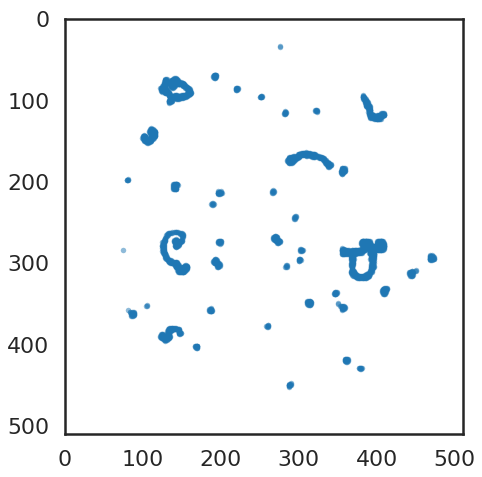

In [22]:
it = 769
th_image      = np.zeros([2048,2048],dtype = 'int') # verficare con il np.round.... np.ceil
th_image[:,:] = 104 # per imostare tutto a 101

#th_image      = np.round(m_image + nsigma*s_image) # verficare con il np.round.... np.ceil

edges_image     = (truth[it][0] > th_image) & (truth[it][0] < cimax)
rebin_image     = cy.rebin(truth[it][0], (rescale, rescale))
rebin_th_image  = cy.rebin(th_image, (rescale, rescale))
edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
points          = np.array(np.nonzero(edges)).T.astype(float)


fig = plt.figure(figsize=(7,7))

plt.scatter(points[:, 1], points[:, 0],**plot_kwds)
plt.xlim(0,511)
plt.ylim(511,0)

np.size(points)

In [ ]:
def get_colorpalette(idb):
    palette = sns.color_palette('deep', np.unique(idb.labels_).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in idb.labels_]
    return colors

In [ ]:
X = points
colorsI = get_colorpalette(clusters)
colorsN = get_colorpalette(naive)


## PLOT Noise Rejection
fig, ax = plt.subplots(1,2,figsize=(16, 8), sharex=True, sharey=True)
ax[0].invert_yaxis()

ax[0].scatter(X[:, 1], X[:, 0], c=colorsI, **plot_kwds)
ax[0].set_title("i2DBSCAN")

ax[1].scatter(X[:, 1], X[:, 0], c=colorsN, **plot_kwds)
ax[1].set_title("Naive DBSCAN")

plt.show()

## Background

In [ ]:
fig = plt.figure(figsize=(15,15))
ax  = plt.gca()

iax = ax.imshow(image,cmap="viridis", vmin=85,vmax=130)
ax.set_xlim(np.min(newX),np.max(newX))
ax.set_ylim(np.max(newY),np.min(newY))
ax.set_title("I%d Run%d + one random long track" % (iTr, runI[0]))
colorbar(iax)
plt.show(block=False)
plt.close()

In [ ]:
# To remove any NaN
s_image[np.isnan(s_image)] = np.mean(s_image[~np.isnan(s_image)])
m_image[np.isnan(m_image)] = np.mean(m_image[~np.isnan(m_image)])

m_image[m_image > 101] = np.mean(m_image[m_image < 101])
s_image[s_image > 4] = np.mean(s_image[s_image < 4])


n_image = np.random.normal(m_image,s_image,[2048,2048])

In [ ]:
fig = plt.figure(figsize=(15,15))
ax  = plt.gca()

iax = ax.imshow(n_image,cmap="viridis", vmin=85,vmax=130)
ax.set_xlim(0,2047)
ax.set_ylim(2047,0)
ax.set_title("Background Image")
colorbar(iax)
plt.show(block=False)
plt.close()